# Task III  Image Super-resolution 
Train a deep learning-based super resolution algorithm of your choice to upscale low-resolution strong lensing images using the provided high-resolution samples as ground truths. Please implement your approach in PyTorch or Keras and discuss your strategy.


This code implements a Generative Adversarial Network (GAN)-based Super-Resolution approach using PyTorch.

You can read [more](https://pyimagesearch.com/2022/06/06/super-resolution-generative-adversarial-networks-srgan/) here about SRGAN(Super Resolution Generative Adversiial Netwrok) 

**Why this approach?**
Using CNN and transformer based approaches could be compute-intensive, harder to train in resource-limited environments, could struggle with fine textures and perceptual quality but with GAN approach it generates sharper images with realistic textures, adversarial learning improves detail restoration. Strong lensing images contain complex patterns, and GANs help generate realistic high-frequency details missing in CNN-based approaches.

In [3]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import warnings


data loading

In [4]:

# Increased Batch Size (64 → from 32) for stable training.
# Useing pin_memory=True and num_workers=4 for faster data loading.
# Optimized Configuration
config = {
    'hr_path': '/kaggle/input/dataset3/Dataset/HR',
    'lr_path': '/kaggle/input/dataset3/Dataset/LR',
    'batch_size': 64,  
    'lr': 2e-4,
    'num_epochs': 12,  
    'scale_factor': 2,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'save_path': './saved_models',
    'num_workers': 4,
    'mixed_precision': True,
    'patience': 3,  
    'validate_every': 2  
}
os.makedirs(config['save_path'], exist_ok=True)


In [5]:

# Optimized Dataset Class
class StrongLensingDataset(Dataset):
    def __init__(self, hr_dir, lr_dir):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        
        self.hr_files = sorted(f for f in os.listdir(hr_dir) if f.endswith('.npy'))
        self.lr_files = sorted(f for f in os.listdir(lr_dir) if f.endswith('.npy'))
        
        sample_hr = np.load(os.path.join(hr_dir, self.hr_files[0]))
        sample_lr = np.load(os.path.join(lr_dir, self.lr_files[0]))
        
        self.hr_shape = sample_hr.squeeze().shape
        self.lr_shape = sample_lr.squeeze().shape
        
        print(f"Dataset with HR: {self.hr_shape}, LR: {self.lr_shape}")

    def __len__(self):
        return len(self.hr_files)
    
    def __getitem__(self, idx):
        hr_img = np.load(os.path.join(self.hr_dir, self.hr_files[idx])).squeeze()
        lr_img = np.load(os.path.join(self.lr_dir, self.lr_files[idx])).squeeze()
        
        hr_img = torch.from_numpy(hr_img.copy()).float().unsqueeze(0)
        lr_img = torch.from_numpy(lr_img.copy()).float().unsqueeze(0)
        
        hr_img = (hr_img - hr_img.min()) / (hr_img.max() - hr_img.min())
        lr_img = (lr_img - lr_img.min()) / (lr_img.max() - lr_img.min())
        
        return lr_img, hr_img


**Generator**
<br>
* Takes a low-resolution image as input and generates a high-resolution version.
* Uses 4 residual blocks (instead of 6) for efficiency.
* PReLU activation for better gradient flow.
* PixelShuffle Upsampling for improved super-resolution performance.
* Sigmoid activation at the final layer to normalize the output.

In [6]:

#  Generator
class Generator(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        nf = 48  # Reduced from 64
        
        self.initial = nn.Sequential(
            nn.Conv2d(1, nf, 3, padding=1),
            nn.PReLU()
        )
        
        # Reduced from 6 to 4 residual blocks
        self.res_blocks = nn.Sequential(*[
            nn.Sequential(
                nn.Conv2d(nf, nf, 3, padding=1),
                nn.BatchNorm2d(nf),
                nn.PReLU(),
                nn.Conv2d(nf, nf, 3, padding=1),
                nn.BatchNorm2d(nf)
            ) for _ in range(4)
        ])
        
        self.upsample = nn.Sequential(
            nn.Conv2d(nf, nf*(scale_factor**2), 3, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.PReLU()
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(nf, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        if x.dim() == 5:
            x = x.squeeze(1)
        x0 = self.initial(x)
        x = self.res_blocks(x0) + x0
        x = self.upsample(x)
        return self.final(x)


**Discriminator**
* Distinguishes between real HR images and generated (fake) images.
* Uses InstanceNorm for better normalization.
* LeakyReLU activation for stable training.
* Outputs a binary prediction indicating whether an image is real or fake.



In [7]:


# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size=150):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 1, 4, stride=2, padding=1)
        )
    
    def forward(self, x):
        if x.dim() == 5:
            x = x.squeeze(1)
        return self.model(x)

# Useing Automatic Mixed Precision (AMP) via torch.amp to reduce memory usage and speed up training.
# Useing GradScaler to avoid underflow in gradient updates.

def train():
    # Initialize
    dataset = StrongLensingDataset(config['hr_path'], config['lr_path'])
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size']*2,  # Larger batches for validation
        num_workers=config['num_workers'],
        pin_memory=True
    )
    
    generator = Generator(config['scale_factor']).to(config['device'])
    discriminator = Discriminator(input_size=dataset.hr_shape[0]).to(config['device'])
    
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_pixel = nn.L1Loss()
    
    optimizer_G = optim.Adam(generator.parameters(), lr=config['lr'], betas=(0.9, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr'], betas=(0.9, 0.999))
    
    scaler = GradScaler('cuda', enabled=config['mixed_precision'])
    
    best_psnr = 0.0
    epochs_no_improve = 0
    
    for epoch in range(config['num_epochs']):
        generator.train()
        discriminator.train()
        
        for i, (lr_imgs, hr_imgs) in enumerate(train_loader):
            lr_imgs = lr_imgs.to(config['device'], non_blocking=True)
            hr_imgs = hr_imgs.to(config['device'], non_blocking=True)
            
            # Get proper target size from discriminator
            with torch.no_grad():
                test_output = discriminator(hr_imgs[:1])
                target_size = test_output.shape[2:]
            
            valid = torch.ones(lr_imgs.size(0), 1, *target_size, device=config['device'])
            fake = torch.zeros(lr_imgs.size(0), 1, *target_size, device=config['device'])
            
            # Train Generator
            optimizer_G.zero_grad(set_to_none=True)
            
            with autocast('cuda', enabled=config['mixed_precision']):
                gen_hr = generator(lr_imgs)
                loss_pixel = criterion_pixel(gen_hr, hr_imgs)
                pred_gen = discriminator(gen_hr)
                loss_GAN = criterion_GAN(pred_gen, valid)
                loss_G = loss_pixel + 0.001 * loss_GAN
            
            scaler.scale(loss_G).backward()
            scaler.step(optimizer_G)
            
            # Train Discriminator
            optimizer_D.zero_grad(set_to_none=True)
            
            with autocast('cuda', enabled=config['mixed_precision']):
                pred_real = discriminator(hr_imgs)
                loss_real = criterion_GAN(pred_real, valid)
                pred_fake = discriminator(gen_hr.detach())
                loss_fake = criterion_GAN(pred_fake, fake)
                loss_D = (loss_real + loss_fake) / 2
            
            scaler.scale(loss_D).backward()
            scaler.step(optimizer_D)
            scaler.update()
            
            if i % 50 == 0:  # Reduced logging frequency
                print(f"[Epoch {epoch+1}/{config['num_epochs']}] [Batch {i}] "
                      f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}")
        
        # Validation (every 'validate_every' epochs)
        if (epoch + 1) % config['validate_every'] == 0:
            generator.eval()
            val_metrics = {'mse': 0.0, 'ssim': 0.0, 'psnr': 0.0}
            
            with torch.no_grad():
                for lr_imgs, hr_imgs in val_loader:
                    lr_imgs = lr_imgs.to(config['device'], non_blocking=True)
                    hr_imgs = hr_imgs.to(config['device'], non_blocking=True)
                    
                    with autocast('cuda', enabled=config['mixed_precision']):
                        fake_hr = generator(lr_imgs)
                    
                    fake_np = fake_hr.squeeze().cpu().numpy()
                    real_np = hr_imgs.squeeze().cpu().numpy()
                    
                    val_metrics['mse'] += np.sum((fake_np - real_np) ** 2)
                    for f, r in zip(fake_np, real_np):
                        val_metrics['ssim'] += ssim(f, r, data_range=1.0)
                        val_metrics['psnr'] += psnr(r, f, data_range=1.0)
            
            val_metrics = {k: v / val_size for k, v in val_metrics.items()}
            
            print(f"\nValidation - MSE: {val_metrics['mse']:.4f}, "
                  f"SSIM: {val_metrics['ssim']:.4f}, PSNR: {val_metrics['psnr']:.4f}\n")
            
            # Early stopping check
            if val_metrics['psnr'] > best_psnr:
                best_psnr = val_metrics['psnr']
                epochs_no_improve = 0
                torch.save(generator.state_dict(), 
                          os.path.join(config['save_path'], 'best_generator.pth'))
                print(f"Saved model with PSNR: {best_psnr:.4f}")
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= config['patience']:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

if __name__ == '__main__':
    train()

Dataset with HR: (150, 150), LR: (75, 75)


/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


[Epoch 1/12] [Batch 0] Loss_D: 0.7269 Loss_G: 0.4412
[Epoch 1/12] [Batch 50] Loss_D: 0.6708 Loss_G: 0.0095
[Epoch 1/12] [Batch 100] Loss_D: 0.6491 Loss_G: 0.0089
[Epoch 2/12] [Batch 0] Loss_D: 0.6041 Loss_G: 0.0082
[Epoch 2/12] [Batch 50] Loss_D: 0.5472 Loss_G: 0.0088
[Epoch 2/12] [Batch 100] Loss_D: 0.5305 Loss_G: 0.0086

Validation - MSE: 2.5782, SSIM: 0.9610, PSNR: 39.4801

Saved model with PSNR: 39.4801
[Epoch 3/12] [Batch 0] Loss_D: 0.5486 Loss_G: 0.0084
[Epoch 3/12] [Batch 50] Loss_D: 0.4888 Loss_G: 0.0074
[Epoch 3/12] [Batch 100] Loss_D: 0.4908 Loss_G: 0.0071
[Epoch 4/12] [Batch 0] Loss_D: 0.4897 Loss_G: 0.0071
[Epoch 4/12] [Batch 50] Loss_D: 0.4884 Loss_G: 0.0079
[Epoch 4/12] [Batch 100] Loss_D: 0.4375 Loss_G: 0.0073

Validation - MSE: 3.3655, SSIM: 0.9467, PSNR: 38.4092

[Epoch 5/12] [Batch 0] Loss_D: 0.4216 Loss_G: 0.0082
[Epoch 5/12] [Batch 50] Loss_D: 0.4011 Loss_G: 0.0073
[Epoch 5/12] [Batch 100] Loss_D: 0.4843 Loss_G: 0.0076
[Epoch 6/12] [Batch 0] Loss_D: 0.4955 Loss_G: 0

<ipython-input-11-df8573e11ea7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('./saved_models/best_generator.pth', map_location='cpu

Dataset with HR: (150, 150), LR: (75, 75)


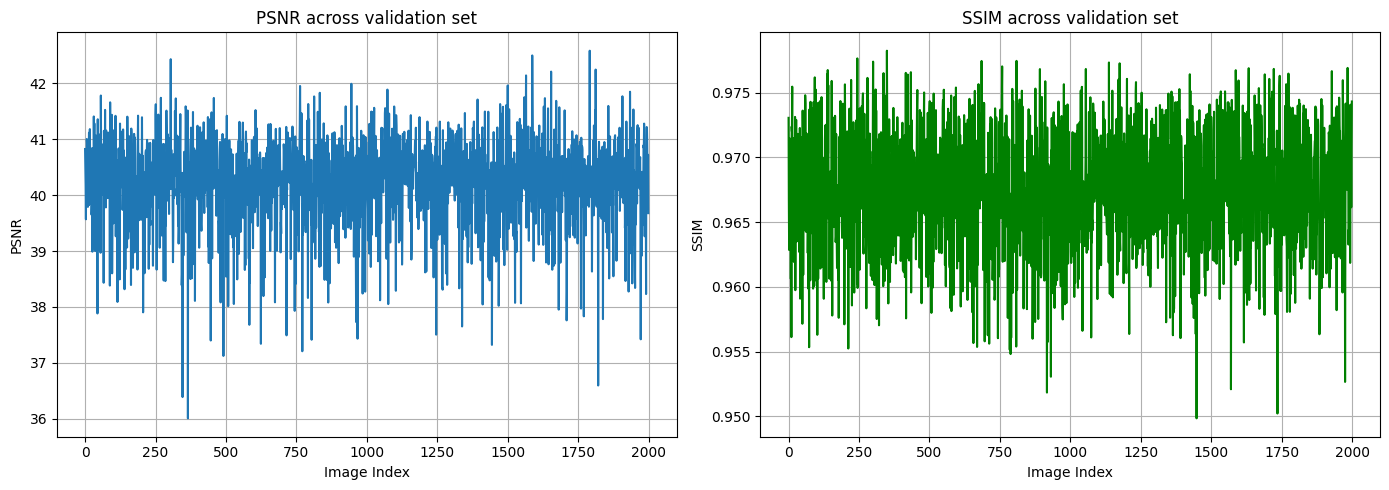

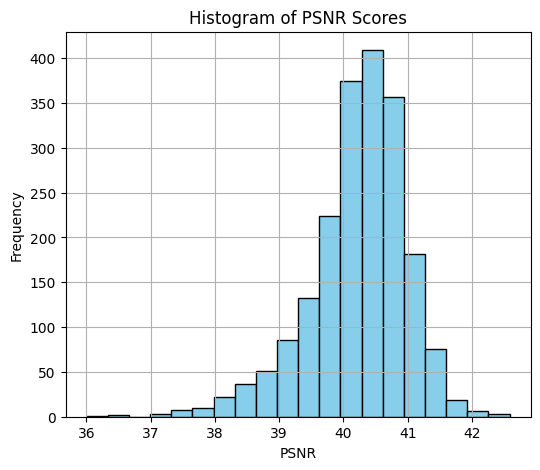

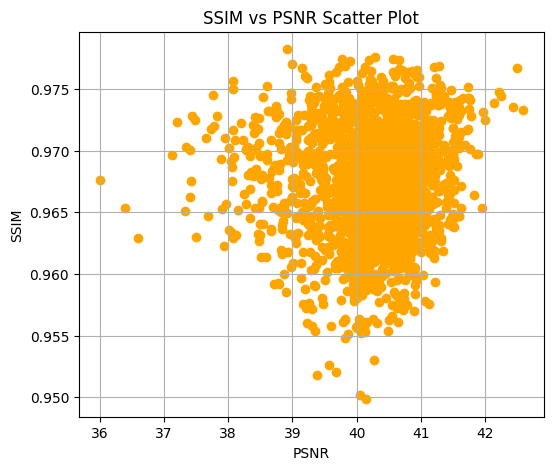

In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Load Model 
generator = Generator(scale_factor=2)
generator.load_state_dict(torch.load('./saved_models/best_generator.pth', map_location='cpu'))
generator.eval().to('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Setup
dataset = StrongLensingDataset(
    hr_dir='/kaggle/input/dataset3/Dataset/HR',
    lr_dir='/kaggle/input/dataset3/Dataset/LR'
)

val_size = int(0.2 * len(dataset))
val_dataset = torch.utils.data.Subset(dataset, range(-val_size, 0))  # last 20% as val
val_loader = DataLoader(val_dataset, batch_size=1)

#  Evaluate 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
psnr_scores, ssim_scores, mse_scores = [], [], []

with torch.no_grad():
    for lr, hr in val_loader:
        lr, hr = lr.to(device), hr.to(device)
        sr = generator(lr)

        hr_np = hr.squeeze().cpu().numpy()
        sr_np = sr.squeeze().cpu().numpy()

        mse = np.mean((hr_np - sr_np) ** 2)
        psnr_val = psnr(hr_np, sr_np, data_range=1.0)
        ssim_val = ssim(hr_np, sr_np, data_range=1.0)

        psnr_scores.append(psnr_val)
        ssim_scores.append(ssim_val)
        mse_scores.append(mse)

#  Plot 1: PSNR and SSIM vs Index 
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(psnr_scores, label='PSNR')
plt.xlabel("Image Index")
plt.ylabel("PSNR")
plt.title("PSNR across validation set")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ssim_scores, label='SSIM', color='green')
plt.xlabel("Image Index")
plt.ylabel("SSIM")
plt.title("SSIM across validation set")
plt.grid(True)

plt.tight_layout()
plt.show()

#  Plot 2: PSNR Histogram 
plt.figure(figsize=(6, 5))
plt.hist(psnr_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of PSNR Scores")
plt.xlabel("PSNR")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

#  Plot 3: SSIM vs PSNR Scatter 
plt.figure(figsize=(6, 5))
plt.scatter(psnr_scores, ssim_scores, c='orange')
plt.xlabel("PSNR")
plt.ylabel("SSIM")
plt.title("SSIM vs PSNR Scatter Plot")
plt.grid(True)
plt.show()


The graphs show consistent PSNR (around 40–41 dB) and SSIM ( around 0.97), indicating high reconstruction quality.

No major outliers or dips suggest the model performs uniformly across the dataset.

Tight correlation between PSNR and SSIM confirms reliable and structurally accurate outputs.